## Directories Required
Ensure you have the following directory structure no matter where you are hosting the data: GCP Storage, GCP Compute Engine local disk, Google Drive or your local desktop/laptop.

The root folder on your local drive should be 'image_caption'. The rest follow from it.<br/>

For Colab, there is one additional requirement. Ensure 'image_caption' is placed under 'Colab Notebooks' folder (which is created by Google automatically the first time you create a Colab notebook). Why? Since files within Google Colab are referenced with their full path starting all the way back to "drive".<br/>
For example:<br/>
filename = 'drive/My Drive/Colab Notebooks/Image Caption/Data/Flickr_8K/Labels/Flickr_8K.token.txt'<br/>
filename = 'drive/My Drive/Colab Notebooks/Image Caption/Data/Flickr_30K/Labels/results.txt'<br/>


<div>
    <img src="https://drive.google.com/uc?id=1DrVeLA0fz0XYrPq0CZs6eAvRZbsB4GE1" alt="Broken URL. Contact Anand Menon." width="60%"/>
</div>

## Files Required
The following files are required to run the code. All the files are shared, so you should ideally be able to copy the entire directory structure. Warning: It is over 2 GB, soon to be 10 GB.<br/>
You will need to recreate the folder structure locally (with files and all) since the code writes files back to it.

[Link to Data folder](https://drive.google.com/open?id=1bQtuMVTyaXCMGMC0XifOC2aKb1UGTSo6)

### Dataset Files: Train, test, validate
* Flickr_8K
  * Data/Flickr_8K/Images/&lt;Images&gt;<br/>
  * Data/Flickr_8K/Labels/&lt;Labels&gt;<br/>
* Flickr_30K
   * Data/Flickr_30K/Images/&lt;Images&gt;<br/>
   * Data/Flickr_30K/Labels/&lt;Labels&gt;<br/>

### Word Vectors File

* Data/Vectors/&lt;Word vector file&gt;<br/>
You only need one of these depending upon how well trained the vectors need to be for your need. The 300D is better (and much bigger) than the 100D file. Alternatively, feel free to use your own.
    * glove.6B.100d.txt
    * glove.6B.300d.txt

### Transfer Learning Net: Features File
In order to speed up training & testing, all features from our underlying transfer learning net are generated in-advance of the train/test code blocks. The first time you run this code, generate the features once by setting GEN_FEATURES = True above. Then set it back to False. The generated file is large, and it will take ~30 minutes to create.

## Change Log
1. 13 Apr: Switched to using GloVe encoding from a custom Embedding layer. The latter has the downside that if the number of training inputs are insufficient, the word embeddings it creates will be bad...and there is no easy way to tell if the number of training inputs are insufficient for this particular part of the net (the learning curves will give a global answer). Using GloVe word vectors eliminates this problem. In addition, it means the net is not having to learn the 'meaning' of words at the same time as it is learning to generate captions; hence less distractions for its nano-brain.
2. 20 Apr: Dropped words that occur less frequently than 0.005% of the time in the corpus consisting of all captions. This tiny filter dramatically dropped the vocabulary from ~7500 words down to ~1100 words. Naturally, performance went up a bit with very little impact to the English of it all.
3. 24 Apr: Switched the underlying pre-trained net over from VGG16 over to Inception v3. VGG16 is a big, plodding net and its architecture older than Inception. Inception also outperformed VGG16 in ImageNet, so overall it helped the performance a bit.
4. 30 Apr: Cleaned up the code a bit and switched over to ResNet. The experiment here was to try and mimic human behaviour a bit more. Humans are great at fill in the blanks: The car is turning &lt;blank&gt;. So what is needed here is an identity function that helps recall prior learned patterns effectively.

In [194]:
#Clear all vars
%reset -f

#Init code
def initialize():
    """
    """
    import sys

    # Init
    dictInit = {}
    dictInit['GEN_FEATURES'] = False  #Set to True if features need to be generated through the underlying pre-trained net
    dictInit['TRAIN_MODEL'] = True  #Set to True if our custom net needs to learn the dataset
    dictInit['TL_MODEL'] = 'Inceptionv3'  #Pre-trained model used for recognizing obects within images. One of Inceptionv3 or VGG16 trained on ImageNet.
    dictInit['MAX_SAMPLES'] = 75000  #Maximum number of samples to train & test with. Set to -1 for training on full train set.
    dictInit['DATASET'] = 'Flickr_30K'  #One of 'Flickr_8K', 'Flickr_30K'

    #Change directory access paths depending upon where you are running
    dictInit['IN_COLAB'] = 'google.colab' in sys.modules
    if dictInit['IN_COLAB']:
        from google.colab import drive  #Access google drive to load data
        drive.mount('/content/drive')
        dictInit['DIR_PREFIX'] = 'drive/My Drive/Colab Notebooks/image_caption/Data/'
    else:
        dictInit['DIR_PREFIX'] = './Data/'  #Local

    #All directory & file names; Train, Validate, Test etc.
    dictInit['DIR_ALL_IMAGES'] = dictInit['DIR_PREFIX'] + dictInit['DATASET'] + '/Images/'
    dictInit['FN_ALL_LABELS'] = dictInit['DIR_PREFIX'] + dictInit['DATASET'] + '/Labels/' + dictInit['DATASET'] + '.captions.txt'
    dictInit['FN_GEN_MODEL'] = dictInit['DIR_PREFIX'] + 'Model/model_transfer_learning_' + dictInit['TL_MODEL'] + '.png'
    dictInit['FN_GEN_RESULT'] = dictInit['DIR_PREFIX'] + 'Model/features_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '.pkl'
    dictInit['FN_TRAIN_MODEL'] = dictInit['DIR_PREFIX'] + 'Model/model_custom_' + dictInit['TL_MODEL'] + '.png'
    dictInit['FN_WEIGHTS'] = dictInit['DIR_PREFIX'] + 'Weights/weights.best_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '.hdf5'
    dictInit['FN_TRAIN_REMODEL'] = dictInit['DIR_PREFIX'] + 'Model/model_custom_from_weights_' + dictInit['TL_MODEL'] + '.png'
    dictInit['FN_TEST_RESULTS'] = dictInit['DIR_PREFIX'] + 'Model/results_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '_' + str(dictInit['MAX_SAMPLES']/5)
    dictInit['FN_LEARN_CURVES'] = dictInit['DIR_PREFIX'] + 'Model/results_lc_' + dictInit['TL_MODEL'] + '_' + dictInit['DATASET'] + '_' + str(dictInit['MAX_SAMPLES']/5)

    #GloVe embeddings
    dictInit['EMBEDDING_DIM'] = 300
    if dictInit['EMBEDDING_DIM'] == 100:
        dictInit['FN_EMBEDDING'] = dictInit['DIR_PREFIX'] + 'Vectors/' + 'glove.6B.100d.txt'
    elif dictInit['EMBEDDING_DIM'] == 300:
        dictInit['FN_EMBEDDING'] = dictInit['DIR_PREFIX'] + 'Vectors/' + 'glove.6B.300d.txt'
    
    #Return
    return dictInit

#Initialize key variables
dictInit = initialize()
for key, val in dictInit.items():
    print(key, '\t', val)
if (dictInit['MAX_SAMPLES'] == -1) or (dictInit['MAX_SAMPLES'] > 100):
    DEBUG = False
else:
    DEBUG = True
print('DEBUG', '\t\t', DEBUG)

GEN_FEATURES 	 False
TRAIN_MODEL 	 True
TL_MODEL 	 Inceptionv3
MAX_SAMPLES 	 75000
DATASET 	 Flickr_30K
IN_COLAB 	 False
DIR_PREFIX 	 ./Data/
DIR_ALL_IMAGES 	 ./Data/Flickr_30K/Images/
FN_ALL_LABELS 	 ./Data/Flickr_30K/Labels/Flickr_30K.captions.txt
FN_GEN_MODEL 	 ./Data/Model/model_transfer_learning_Inceptionv3.png
FN_GEN_RESULT 	 ./Data/Model/features_Inceptionv3_Flickr_30K.pkl
FN_TRAIN_MODEL 	 ./Data/Model/model_custom_Inceptionv3.png
FN_WEIGHTS 	 ./Data/Weights/weights.best_Inceptionv3_Flickr_30K.hdf5
FN_TRAIN_REMODEL 	 ./Data/Model/model_custom_from_weights_Inceptionv3.png
FN_TEST_RESULTS 	 ./Data/Model/results_Inceptionv3_Flickr_30K_15000.0
FN_LEARN_CURVES 	 ./Data/Model/results_lc_Inceptionv3_Flickr_30K_15000.0
EMBEDDING_DIM 	 300
FN_EMBEDDING 	 ./Data/Vectors/glove.6B.300d.txt
DEBUG 		 False


In [195]:
#Generate features via underlying pre-trained net
if dictInit['GEN_FEATURES']:
    from pickle import dump
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    from keras.models import Model
    from keras.utils import plot_model
    from os import listdir
    import time
    
    #Config
    if dictInit['TL_MODEL'] == 'Inceptionv3':
        from keras.applications import InceptionV3
        from keras.applications.inception_v3 import preprocess_input
    else:        
        from keras.applications.vgg16 import VGG16
        from keras.applications.vgg16 import preprocess_input

    #Extract features from each photo in the directory
    def extract_features(directory):
        """
        """
        #Load Model
        if dictInit['TL_MODEL'] == 'Inceptionv3':
            model = InceptionV3(include_top=False, weights='imagenet')
        else:
            model = VGG16(include_top=False, weights='imagenet')

        #Remove the top layer, retaining the features generated up-to the layer below
        #model.layers.pop()
        model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
        #print(model.summary())
        plot_model(model, to_file = dictInit['FN_GEN_MODEL'], show_shapes=True)

        #Extract features from each photo
        TARGET_SIZE = (0,0)
        if dictInit['TL_MODEL'] == 'Inceptionv3':
            TARGET_SIZE = (299, 299)
        else:
            TARGET_SIZE=(224, 224)
        counter = 0
        features = dict()
        start = time.time()
        current = start
        for fn in listdir(directory):
            #Load image
            image = load_img(directory+'/'+fn, target_size=TARGET_SIZE, interpolation='bicubic')

            #Expand dims to include batch size
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

            #Prepare & predict
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[fn] = feature
            if counter % 1000 == 0:
                if counter == 0:
                    print(counter, 0, fn)
                else:
                    print(counter, 1000.0/(time.time()-current), (time.time()-current), time.time(), fn)
                current = time.time()
            counter += 1
        return features

    # Extract features from all images
    features = extract_features(dictInit['DIR_ALL_IMAGES'])
    print('# of Extracted Features: %d' % len(features), (current-start)/60.0)

    # Save to file
    dump(features, open(dictInit['FN_GEN_RESULT'], 'wb'))

In [196]:
#Load provided filename
def read_file(filename, max_lines=-1):
    """
    """
    with open(filename) as f:
        if max_lines > 0:
            doc = [next(f) for x in range(max_lines)]  #Read only the # of lines specified
        else:
            doc = f.read().splitlines()  #Read all lines
        return doc

#Load captions
doc = read_file(dictInit['FN_ALL_LABELS'], dictInit['MAX_SAMPLES'])
print(type(doc), len(doc), '\n')
if DEBUG:
    print(doc[0:10])

<class 'list'> 75000 



In [197]:
#Extracts name and captions associated with each image
def extract_captions(doc):
    """
    """
    #If dataset Flickr_8K...
    lines = []
    if dictInit['DATASET'] == 'Flickr_8K':
        #Split on tabs
        for line in doc:
            if line.strip() == '':
                continue
            tokens = line.split('\t')
            #Skip '_577c3a7d70....#1' part of name  #1001773457_577c3a7d70.jpg#1	Two dogs are playing with each other .
            photo_id = tokens[0].split('_')[0]+'.'+tokens[0].split('.')[1][0:-2]
            photo_caption = tokens[1]  #Rest of words
            lines.append((photo_id, photo_caption))
    elif dictInit['DATASET'] == 'Flickr_30K':
        #Split on pipes
        first = True  #Skip header "image_name| comment_number| comment"
        for line in doc:
            if (first) or (line.strip() == ""):
                first = False
                continue
            tokens = line.split('|')
            photo_id = tokens[0]
            photo_caption = tokens[2]
            lines.append((photo_id, photo_caption))

    #Concatenate descriptions by image
    dictCaptions = {}  #Key = Photo identifier, Value = List of captions
    for tokens in lines:
        photo_id = tokens[0]
        photo_caption = tokens[1]
        if photo_id not in dictCaptions:
            dictCaptions[photo_id] = []
        dictCaptions[photo_id].extend([photo_caption])
    return dictCaptions

#Extract all words and captions
dictCaptions = extract_captions(doc)
print('# of samples:', len(dictCaptions), '\n')
if DEBUG:
    counter = 0
    for key,val in dictCaptions.items():
        print(key,val)
        if counter>2:
            break;
        counter += 1

# of samples: 15000 



In [198]:
import re

#Cleanup text
def cleanup_text(dictCaptions):
    """
    Remove punctuation & special characters, lowercase captions, remove hanging 's, remove extra spaces.
    Returns the sum of # of words across all captions. Includes duplicate counts.
    """
    #Pre-process
    for id, captions in dictCaptions.items():
        clean = []
        for caption in captions:
            desc = caption.lower().replace(" 's", "s")
            desc = re.sub('[^A-Za-z0-9 ]+', '', desc)  #Remove punc & special chars
            desc = desc.replace('   ', ' ').replace('  ', ' ').strip()
            clean.append(desc)
        dictCaptions[id] = clean

#Cleanup text
cleanup_text(dictCaptions)
if DEBUG:
    counter = 0
    for key,val in dictCaptions.items():
        print(key,val)
        if counter>2:
            break;
        counter += 1

In [199]:
import random

#Aggregate words across all captions
def agg_words(dictCaptions):
    """
    """
    allWordsInCaptions = []
    for id, captions in dictCaptions.items():
        for caption in captions:
            allWordsInCaptions.extend(caption.split(' '))
    return allWordsInCaptions

#Count frequency of all words
def count_word_freq(dictCaptions):
    """
    """
    #Aggregate words across all captions
    allWordsInCaptions = agg_words(dictCaptions)
    numWords = len(allWordsInCaptions)
    
    #Count
    dictWords = {}
    for word in allWordsInCaptions:
        if word not in dictWords:
            dictWords[word] = 0
        dictWords[word] += 1
    return numWords, dictWords

#Count frequency of all words
numWords, dictWords = count_word_freq(dictCaptions)
print('# of total words across all captions:', numWords)
print('# of unique words:', len(dictWords), '\n')
if DEBUG:
    for key in random.sample(list(dictWords.keys()), 5):
        print(key+':', dictWords[key])

# of total words across all captions: 886815
# of unique words: 14037 



In [200]:
#Drop infrequent words from captions, reducing vocabulary size
def drop_infrequent(dictCaptions, dictWords):
    """
    """
    #Form dict of frequent words
    truncated = []
    for word in dictWords.keys():
        if dictWords[word]/numWords > 0.00005:  #0.005%
            truncated.append(word)
    dictWordsTrunc = dict.fromkeys(truncated , 0)

    #Drop infrequent
    for id, captions in dictCaptions.items():
        newCaptions = []
        for cap in captions:
            #newCaptions.append(' '.join([word for word in cap.split(' ') if word in dictWordsTrunc]))
            newCaption = []
            for word in cap.split(' '):
                if word in dictWordsTrunc:
                    newCaption.append(word)
            newCaptions.append(' '.join(newCaption))
        dictCaptions[id] = newCaptions

#Drop infrequent words
drop_infrequent(dictCaptions, dictWords)
print('Total samples:', len(dictCaptions))
print('# of total words across all captions:', len(agg_words(dictCaptions)))
print('# of unique words:', len(set(agg_words(dictCaptions))), '\n')
if DEBUG:
    for key in random.sample(list(dictCaptions.keys()), 5):
        print(key, dictCaptions[key])

Total samples: 15000
# of total words across all captions: 815742
# of unique words: 1343 



Top 3 sequence lengths: [72, 71, 68]


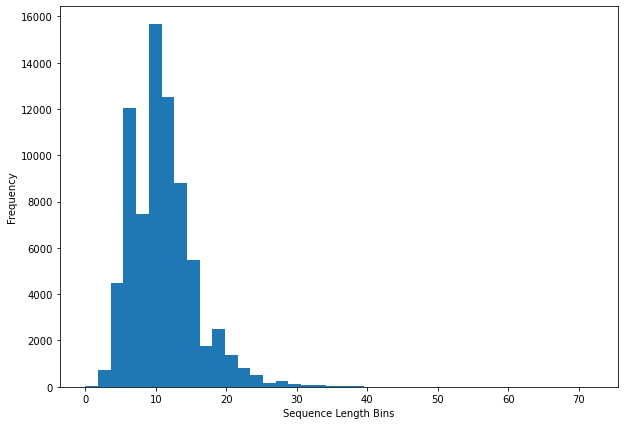

Skew: 1.3614995053076038
99th Percentile: 26


In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

#4 May: Limit caption length to 95% percentile
seq_lengths = [len(val.split()) for values in dictCaptions.values() for val in values]
seq_lengths.sort(reverse=True)
print('Top 3 sequence lengths:', seq_lengths[0:3])

#Histogram
plt.rcParams['figure.facecolor'] = 'white'
fig=plt.figure(figsize=(7, 5))
numBins = 40
plt.hist(seq_lengths, bins=numBins)
plt.xlabel('Sequence Length Bins', color='black')
plt.ylabel('Frequency', color='black')
# plt.spines['bottom'].set_color('lightgrey')
# ax.spines['left'].set_color('lightgrey')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.tick_params(axis='x', colors='black')
# ax.tick_params(axis='y', colors='black')
plt.show()
print('Skew:', round(skew(seq_lengths),3))

#Get the 99'th percentile
p99 = int(np.percentile(seq_lengths, 99))  #N'th percentile
print('99th Percentile:', p99)

#Trunc captions to p99
for id, captions in dictCaptions.items():
    newCaptions = []
    for cap in captions:
        newCaptions.append(' '.join(cap.split(' ')[0:p99]))
    dictCaptions[id] = newCaptions
counter = 0
if DEBUG:
    for id, captions in dictCaptions.items():
        print(id)
        for cap in captions:
            print('\t', cap)
        if counter > 3:
            break;
        counter += 1

In [202]:
from sklearn.model_selection import train_test_split

#Create train, dev & test datasets
def split_dataset(dictCaptions):
    #Split
    X = list(dictCaptions.keys())
    y = list(dictCaptions.values())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)  #Train+Dev vs. Test
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.10, random_state=42)  #Train vs. Dev
    return X_train, X_dev, X_test, y_train, y_dev, y_test

#Split
X_train, X_dev, X_test, y_train, y_dev, y_test = split_dataset(dictCaptions)
print(len(X_train)+len(X_test)+len(X_dev), ':', len(X_train), len(X_test), len(X_dev))
print(len(y_train)+len(y_test)+len(y_dev), ':', len(y_train), len(y_test), len(y_dev))

15000 : 10800 3000 1200
15000 : 10800 3000 1200


In [203]:
import numpy as np
from numpy import array
from pickle import dump
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#Flatten sets and add startseq endseq bookends
def flatten_add_bookends(X, y):
    """
        X is list of photo ID's.
        y is a list of captions (usually 5) for each photo.
    """
    Xy = []
    idx = 0
    for captions in y:
        Xy.extend([[X[idx], 'startseq ' + cap + ' endseq'] for cap in captions])
        idx += 1
    return Xy

#Create inputs images, input sequences and output words for an image
def create_sequences(tokenizer, max_seq_len, Xy, features, vocab_size):
    """
    """
    #Foreach sample...
    X1, X2, y = list(), list(), list()
    for key, value in Xy:
        #Encode: text to integers
        seq = tokenizer.texts_to_sequences([value])[0]
        
        #Split sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            #Split
            in_seq, out_seq = seq[:i], seq[i]
            
            #Pad input sequences
            in_seq = pad_sequences([in_seq], maxlen = max_seq_len)[0]
            
            #Encode output sequence: 
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            
            #Store
            X1.append(features[key][0])
            X2.append(in_seq)
            y.append(out_seq)
    return (array(X1), array(X2), array(y))

#Convert the dataset into the right format for our custom net + LSTM
def process_dataset(X_train, X_dev, X_test, y_train, y_dev, y_test):
    #Flatten sets ++ startseq endseq bookends
    Xy_train = flatten_add_bookends(X_train, y_train)
    Xy_dev = flatten_add_bookends(X_dev, y_dev)
    Xy_test = flatten_add_bookends(X_test, y_test)
    
    #Compute max length of tokens in train set
    max_seq_len = max([len(token.split(' ')) for val in Xy_train for token in val])
    
    #Create tokenizer and fit on train set
    only_captions = [val[1] for val in Xy_train]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(only_captions)
    
    #Load transfer learning features from pickle file
    features_all = load(open(dictInit['FN_GEN_RESULT'], 'rb'))
    features_train = {k: features_all[k] for k in X_train}
    features_dev = {k: features_all[k] for k in X_dev}
    features_test = {k: features_all[k] for k in X_test}
    
    #Create training sequences
    vocab_size = len(tokenizer.word_index) + 1
    Xy_train_seq = create_sequences(tokenizer, max_seq_len, Xy_train, features_train, vocab_size)  #X1train, X2train, ytrain
    
    #Create dev sequences
    Xy_dev_seq = create_sequences(tokenizer, max_seq_len, Xy_dev, features_dev, vocab_size)  #X1dev, X2dev, ydev
    
    #Create test sequences
    Xy_test_seq = create_sequences(tokenizer, max_seq_len, Xy_test, features_test, vocab_size)  #X1test, X2test, ytest
    
    #Add features into Xy_train, Xy_dev & Xy_test for use in testing later (only need test but doing the rest for debugging consistency)
    Xy_train = [(features_train[Xy_train[idx][0]], Xy_train[idx][0], Xy_train[idx][1]) for idx,val in enumerate(Xy_train)]
    Xy_dev = [(features_dev[Xy_dev[idx][0]], Xy_dev[idx][0], Xy_dev[idx][1]) for idx,val in enumerate(Xy_dev)]
    Xy_test = [(features_test[Xy_test[idx][0]], Xy_test[idx][0], Xy_test[idx][1]) for idx,val in enumerate(Xy_test)]
    
    #Return
    return tokenizer, max_seq_len, vocab_size, \
            Xy_train, Xy_dev, Xy_test, \
            Xy_train_seq, Xy_dev_seq, Xy_test_seq

#Process dataset
tokenizer, max_seq_len, vocab_size, Xy_train, Xy_dev, Xy_test, Xy_train_seq, Xy_dev_seq, Xy_test_seq = \
                                                    process_dataset(X_train, X_dev, X_test, y_train, y_dev, y_test)
print('Longest sequence length:', max_seq_len)
print('Vocabulary size:', vocab_size, '\n')
print(len(Xy_train), '\t', len(Xy_dev), '\t', len(Xy_test))
print(len(Xy_train_seq), '\t', len(Xy_dev_seq), '\t', len(Xy_test_seq))
print(Xy_train_seq[0].shape, '\t', Xy_train_seq[1].shape, '\t', Xy_train_seq[2].shape)
print(Xy_dev_seq[0].shape, '\t', Xy_dev_seq[1].shape, '\t', Xy_dev_seq[2].shape)
print(Xy_test_seq[0].shape, '\t', Xy_test_seq[1].shape, '\t', Xy_test_seq[2].shape)

Longest sequence length: 28
Vocabulary size: 1345 

53999 	 6000 	 15000
3 	 3 	 3
(638838, 2048) 	 (638838, 28) 	 (638838, 1345)
(71337, 2048) 	 (71337, 28) 	 (71337, 1345)
(177650, 2048) 	 (177650, 28) 	 (177650, 1345)


## Create & Run Model

In [204]:
import time

#Create a matrix of GloVe word vectors of all words in our vocabulary
def createEmbeddingMatrix(dict_word_index, vocab_size):
    #Load GloVe word vectors
    start = time.time()
    dict_glove = {}
    lines = read_file(dictInit['FN_EMBEDDING'])
    with open(dictInit['FN_EMBEDDING']) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            dict_glove[word] = coefs
    print('# of vectors loaded:', len(dict_glove))
    print('Time taken:', time.time()-start)

    #Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, dictInit['EMBEDDING_DIM']))
    for word, i in dict_word_index.items():
        embedding_vector = dict_glove.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  #Words not found in GloVe will be all-zeros
    return embedding_matrix

#Create a matrix of GloVe word vectors of all words in our vocabulary
print('Loading vectors...')
if dictInit['TRAIN_MODEL']:
    embedding_matrix = createEmbeddingMatrix(tokenizer.word_index, vocab_size)
    print(embedding_matrix.shape)

Loading vectors...
# of vectors loaded: 400000
Time taken: 36.02288866043091
(1345, 300)


In [205]:
if dictInit['TRAIN_MODEL']:
    from keras.applications import densenet
    from keras.models import Model
    from keras.layers import Input
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Embedding
    from keras.layers import Dropout
    from keras.layers.merge import add
    from keras.callbacks import ModelCheckpoint
    from keras.utils import plot_model
    
    #Define the captioning model
    def define_model(vocab_size, max_seq_len):
        """
        """
        # feature extractor model
        if dictInit['TL_MODEL'] == 'Inceptionv3':
            inputs1 = Input(shape=(2048,))
        else:
            inputs1 = Input(shape=(4096,))
        fe1 = inputs1  #Dropout(0.2)(inputs1)
        fe2 = Dense(400, activation='relu')(fe1)
        
        # sequence model
        inputs2 = Input(shape=(max_seq_len,))
        # se1 = Embedding(vocab_size, 300, mask_zero=True)(inputs2)
        se1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)(inputs2)
        se2 = se1  #Dropout(0.2)(se1)
        se3 = LSTM(400)(se2)
        
#         # decoder model
#         decoder1 = add([fe2, se3])
#         decoder2 = Dense(500, activation='relu')(decoder1)
#         outputs = Dense(vocab_size, activation='softmax')(decoder2)
        
#         # tie it together [image, seq] [word]
#         model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#         model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
        
        # decoder model
        decoder1 = add([fe2, se3])
        decoder2 = Dense(500, activation='relu')(decoder1)
        outputs = Dense(vocab_size, activation='softmax')(decoder2)
        
        # tie it together [image, seq] [word]
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
        
        # summarize model
        print(model.summary())
        plot_model(model, to_file=dictInit['FN_TRAIN_MODEL'], show_shapes=True)
        return model

    # fit model

    # define the model & checkpoint callback
    start = time.time()
    print('Start time:', start)
    model = define_model(vocab_size, max_seq_len)
    checkpoint = ModelCheckpoint(dictInit['FN_WEIGHTS'], monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # fit model
    history = model.fit([Xy_train_seq[0], Xy_train_seq[1]], Xy_train_seq[2], epochs=3, 
              verbose=2, callbacks=[checkpoint], validation_data=([Xy_dev_seq[0], Xy_dev_seq[1]], Xy_dev_seq[2]))
    print('Total time taken:', time.time()-start)

Start time: 1588636744.5009882
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 28)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 28, 300)      403500      input_21[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 400)          819600      input_20[0][0]                   
____________________________________________________________

## Model Evaluation

<Figure size 1584x1728 with 0 Axes>

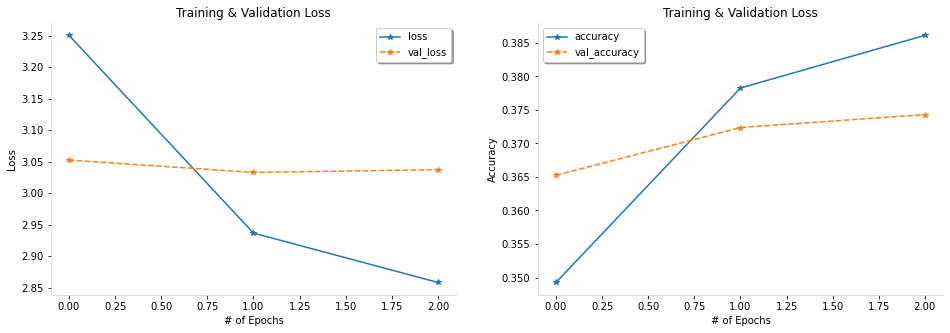

In [206]:
from datetime import datetime
import matplotlib.pyplot as plt
    
#Init plot
plt.rcParams['figure.facecolor'] = 'white'
fig=plt.figure(figsize=(22, 24))

#Plot learning curves
def plotCurve(ax, metric1, metric2, title, title_x, title_y):
    ax.plot(history.history[metric1], '-*', label=metric1)
    ax.plot(history.history[metric2], '--*', label=metric2)
    ax.set_title('Training & Validation Loss', color='black')
    ax.legend(loc='best', shadow=True)
    ax.set_xlabel(title_x, color='black')
    ax.set_ylabel(title_y, color='black')
    ax.spines['bottom'].set_color('lightgrey')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')

#Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plotCurve(ax1, 'loss', 'val_loss', 'Training & Valiation Loss', '# of Epochs', 'Loss')
plotCurve(ax2, 'accuracy', 'val_accuracy', 'Training & Valiation Accuracy', '# of Epochs', 'Accuracy')
plt.savefig(dictInit['FN_LEARN_CURVES'] + '_' + datetime.today().strftime('%Y-%m-%d-%H:%M:%S') + '.png',
                                                                        bbox_inches='tight', facecolor='white')
plt.show()

In [207]:
from numpy import argmax
from keras.models import load_model
from keras.models import Model
from keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu

# map an integer to a word
def word_for_id(integer, tokenizer):
    """
    """
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo_features, max_seq_len):
    """
    """
    # seed the generation process
    in_text = 'startseq'
    
    # iterate over the whole length of the sequence
    for i in range(max_seq_len):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad input
        sequence = pad_sequences([sequence], maxlen = max_seq_len)
        
        # predict next word
        yhat = model.predict([photo_features,sequence], verbose = 0)
        
        # convert probability to integer
        yhat = argmax(yhat)
        
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        
        # stop if we cannot map the word
        if word is None:
            break
        
        # append as input for generating the next word
        in_text += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

#Stores an instance of a test case
class XyTest:
    def __init__(self, photo_id, features):
        self.photo_id = photo_id
        self.features = features
        self.descriptions = list()
        self.prediction = []
    
    def addPrediction(self, prediction):
        self.prediction = prediction.replace('startseq ','').replace(' endseq','').split(' ')
    
    def addDescription(self, description):
        self.descriptions.append(description.replace('startseq ','').replace(' endseq','').split(' '))
        
    def toString(self):
        res = self.photo_id + '\n'
        for desc in self.descriptions:
            res += '\t' + desc + '\n'
        if len(self.prediction):
            res += '\t' + self.prediction + '\n'
        return res

#Evaluate model
def evaluate_model(model, Xy_test, tokenizer, max_seq_len):
    """
    """
    #Convert Xy_test to dict: Key = photo_id, Value = List of descriptions
    dictXy_test = {}
    for photo_features, photo_id, photo_description in Xy_test:
        if photo_id not in dictXy_test:
            dictXy_test[photo_id] = XyTest(photo_id, photo_features)
        dictXy_test[photo_id].addDescription(photo_description)
    
    #Predict caption foreach test case...
    for photo_id, xyTest in dictXy_test.items():
        photo_features = xyTest.features
        photo_descriptions = xyTest.descriptions  #Actual
        yhat = generate_desc(model, tokenizer, photo_features, max_seq_len)  #Predicted description
        xyTest.addPrediction(yhat)
    
    #Format input for BLEU
    candidate, references = list(), list()
    for photo_id, xyTest in dictXy_test.items():
        references.append(xyTest.descriptions)
        candidate.append(xyTest.prediction)
    
    #Compute BLEU score
    print('BLEU-1: %f' % corpus_bleu(references, candidate, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(references, candidate, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(references, candidate, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25)))
    
    #Return
    return dictXy_test

# load the model
model_custom_from_weights = load_model(dictInit['FN_WEIGHTS'])
# print(model_custom_from_weights.summary())
plot_model(model_custom_from_weights, to_file = dictInit['FN_TRAIN_REMODEL'], show_shapes=True)

# evaluate model
print('Evaluating model...')
start = time.time()
dictXy_test = evaluate_model(model_custom_from_weights, Xy_test, tokenizer, max_seq_len)
print('Time taken:', time.time()-start)

Evaluating model...
BLEU-1: 0.499606
BLEU-2: 0.313718
BLEU-3: 0.228558
BLEU-4: 0.126599
Time taken: 189.95644283294678


In [208]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model

#Config model imports
if dictInit['TL_MODEL'] == 'Inceptionv3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input
else:
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

#Load Model
if dictInit['TL_MODEL'] == 'Inceptionv3':
    model_TL = InceptionV3(include_top=True, weights='imagenet')
else:
    model_TL = VGG16(include_top=True, weights='imagenet')

#Restructure the model
model_TL.layers.pop()
model_TL = Model(inputs = model_TL.inputs, outputs = model_TL.layers[-1].output)
print('Done')

Done


['3456579559.jpg', '253109856.jpg', '2786299623.jpg', '2710698257.jpg', '16158623.jpg', '2429366041.jpg', '2902922070.jpg', '2772532341.jpg', '2404406118.jpg', '3291587911.jpg', '2537596840.jpg', '2795866891.jpg', '2982928615.jpg', '1343787097.jpg', '3407317539.jpg', '2299558545.jpg']


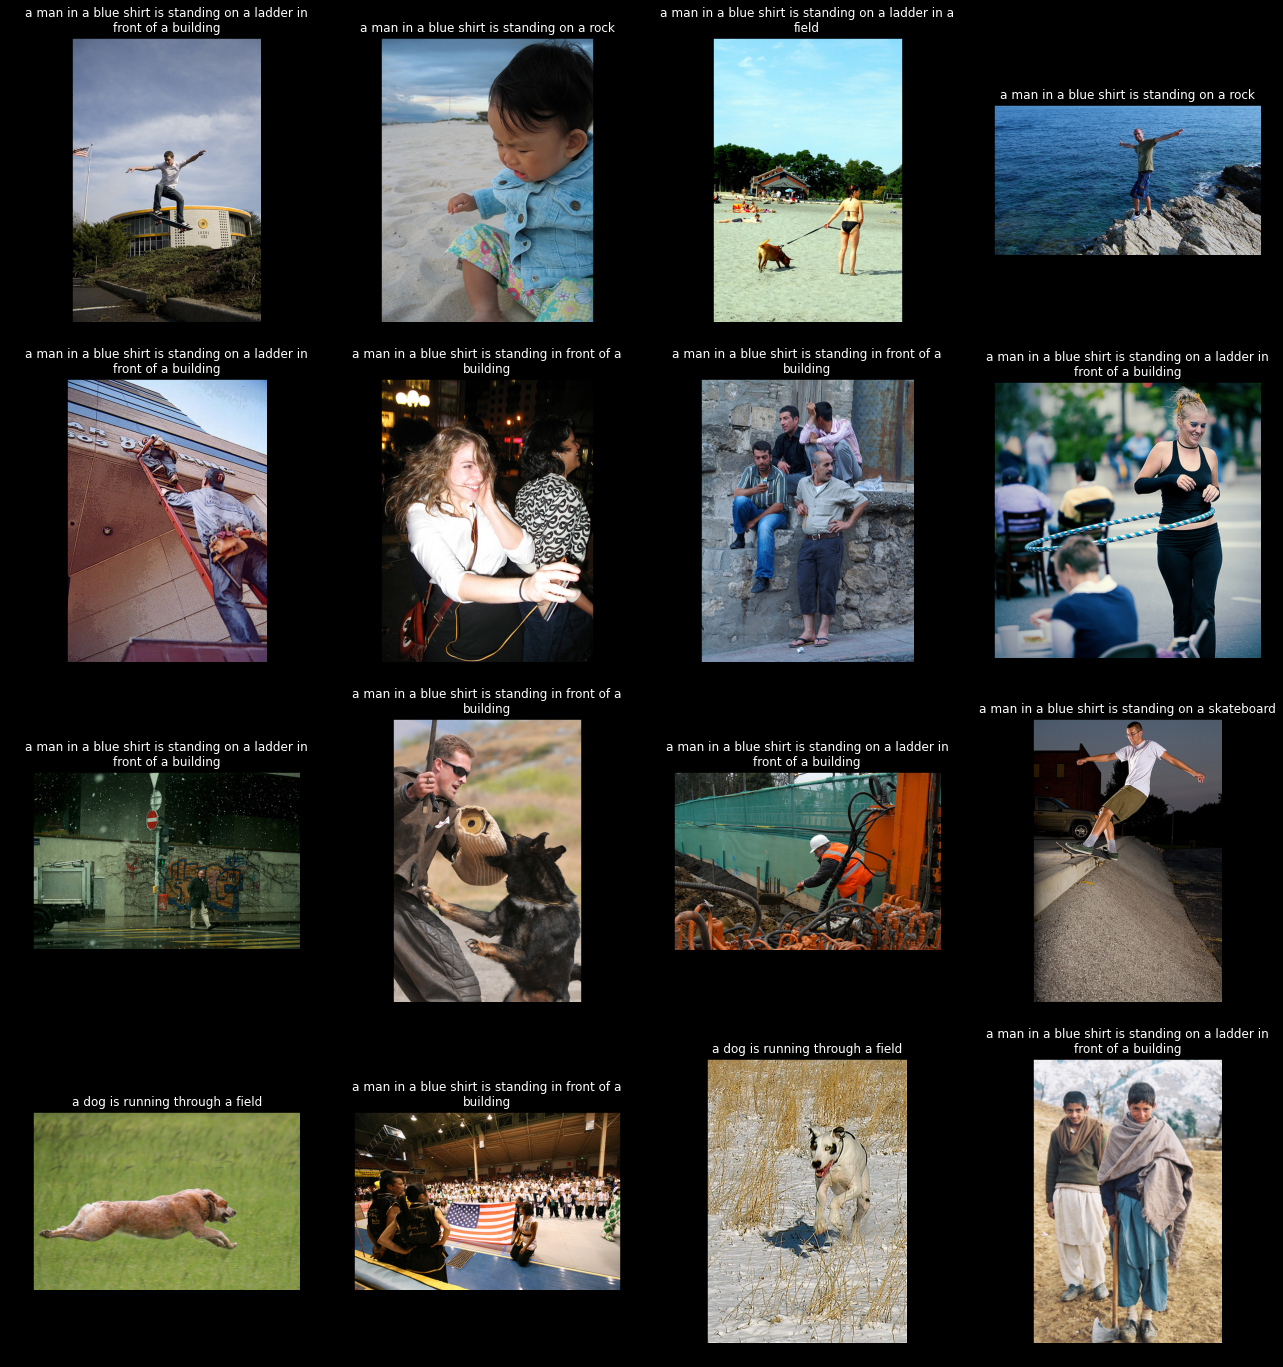

In [209]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from textwrap import wrap

#Plot sample test images
def plotSamples(dictXy_test):
    #Get random images
    testIDs = random.sample(dictXy_test.keys(), 16)
    print(testIDs)
    
    #Init plot
    plt.rcParams['figure.facecolor'] = 'black'
    fig=plt.figure(figsize=(22, 24))
    fig.patch.set_facecolor('black')
    columns = 4
    rows = 4
    
    #Plot
    for i in range(1, columns*rows+1):
        #Prediction
        yhat = ' '.join(dictXy_test[testIDs[i-1]].prediction)
        
        #Plot image and description together
        img = mpimg.imread(dictInit['DIR_ALL_IMAGES']+testIDs[i-1])
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title("\n".join(wrap(yhat, 50)), color='white')
        ax.set_facecolor('xkcd:black')
        plt.imshow(img)
    plt.savefig(dictInit['FN_TEST_RESULTS']+'_'+datetime.today().strftime('%Y-%m-%d-%H:%M:%S')+'.png',
                bbox_inches='tight', facecolor='black', dpi = 50)
    plt.show()

#Plot sample test images
plotSamples(dictXy_test)

## References

Papineni K, Roukos S, Ward T, Zhu W, (Jul 2002), [BLEU: a method for automatic evaluation of machine translation, Proceedings of the 40th Annual Meeting on Association for Computational Linguistics](https://dl.acm.org/doi/10.3115/1073083.1073135)

Szegedy C et al., (Sep 2014), [Going Deeper with Convolutions,  arXiv:1409.4842 cs.CV](https://arxiv.org/abs/1409.4842)

Simonyan K, Zisserman A, (Sep 2014), [Very Deep Convolutional Networks for Large-Scale Image Recognition, arXiv:1409.1556 cs.CV](https://arxiv.org/abs/1409.1556)

Tanti M, Gatt A, Camilleri K.P., (Aug 2017), [What is the Role of Recurrent Neural Networks (RNNs) in an Image Caption Generator?, arXiv:1708.02043 cs.CL](https://arxiv.org/abs/1708.02043)

Brownlee J., (Jun 2019), [How to Develop a Deep Learning Photo Caption Generator from Scratch, Machine Learning Mastery](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

Plummer B. et al., (May 2015), [Flickr30K Entities: Collecting Region-to-Phrase Correspondences for Richer Image-to-Sentence Models, arXiv:1505.04870 cs.CV](https://arxiv.org/abs/1505.04870)